In [29]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📦 Epoch [1/10] Loss: 0.1804
📦 Epoch [2/10] Loss: 0.1031
📦 Epoch [3/10] Loss: 0.0878
📦 Epoch [4/10] Loss: 0.0903
📦 Epoch [5/10] Loss: 0.0821
📦 Epoch [6/10] Loss: 0.0878
📦 Epoch [7/10] Loss: 0.0770
📦 Epoch [8/10] Loss: 0.0739
📦 Epoch [9/10] Loss: 0.0763
📦 Epoch [10/10] Loss: 0.0778
✅ Train Accuracy: 98.20%
🧪 Test Accuracy: 97.55%

📊 Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.97      0.98      1000
        dogs       0.97      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



C:\Users\USER\AppData\Local\Temp\ipykernel_1284\3599352465.py:123: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


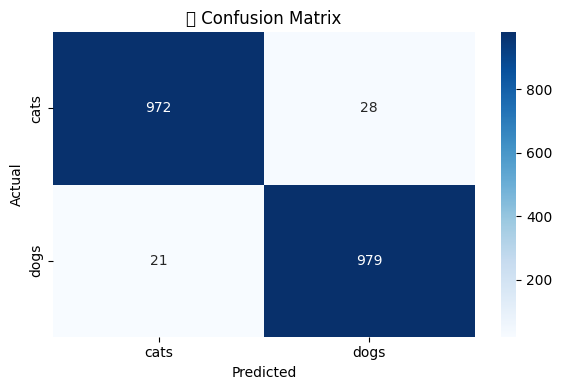

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ✅ ใช้ GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ เตรียม transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # mean สำหรับ MobileNet pretrained 
                         [0.229, 0.224, 0.225])   # std
])

# ✅ โหลด dataset
train_dataset = ImageFolder("train_dataset", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder("test_dataset", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ โหลด MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# ✅ แช่ค่า weights ของ pretrained layers
for param in model.features.parameters():
    param.requires_grad = False

# ✅ ปรับ classifier สำหรับ binary classification (หมา/แมว)
model.classifier[1] = nn.Linear(model.last_channel, 1)

model = model.to(device)

# ✅ Loss และ Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ เทรนโมเดล
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # binary

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"📦 Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")
# --- วัด Train Accuracy ---
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

train_acc = correct / total
print(f"✅ Train Accuracy: {train_acc * 100:.2f}%")

# --- วัด Test Accuracy ---
correct = 0
total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")

# --- Classification Report ---
y_true = np.array(test_labels).flatten()
y_pred = np.array(test_preds).flatten()
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('🧾 Confusion Matrix')
plt.tight_layout()
plt.show()



In [41]:
# เพิ่มไว้ก่อนลูป epoch
train_losses = []
train_accuracies = []
test_accuracies = []


In [42]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # --- คำนวณ Test Accuracy ในแต่ละ epoch ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_epoch_acc = correct / total
    test_accuracies.append(test_epoch_acc)

    print(f"📦 Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Test Acc: {test_epoch_acc:.4f}")


📦 Epoch [1/10] Loss: 0.0718 | Train Acc: 0.9699 | Test Acc: 0.9780
📦 Epoch [2/10] Loss: 0.0618 | Train Acc: 0.9764 | Test Acc: 0.9770
📦 Epoch [3/10] Loss: 0.0720 | Train Acc: 0.9716 | Test Acc: 0.9780
📦 Epoch [4/10] Loss: 0.0749 | Train Acc: 0.9704 | Test Acc: 0.9765
📦 Epoch [5/10] Loss: 0.0767 | Train Acc: 0.9695 | Test Acc: 0.9765
📦 Epoch [6/10] Loss: 0.0739 | Train Acc: 0.9699 | Test Acc: 0.9750
📦 Epoch [7/10] Loss: 0.0653 | Train Acc: 0.9754 | Test Acc: 0.9780
📦 Epoch [8/10] Loss: 0.0645 | Train Acc: 0.9745 | Test Acc: 0.9795
📦 Epoch [9/10] Loss: 0.0698 | Train Acc: 0.9711 | Test Acc: 0.9790
📦 Epoch [10/10] Loss: 0.0729 | Train Acc: 0.9718 | Test Acc: 0.9770


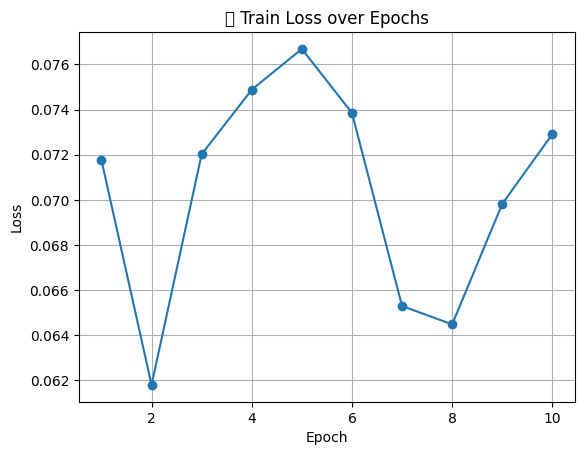

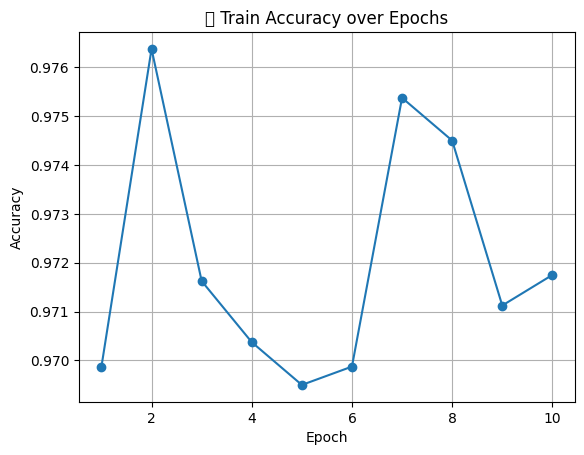

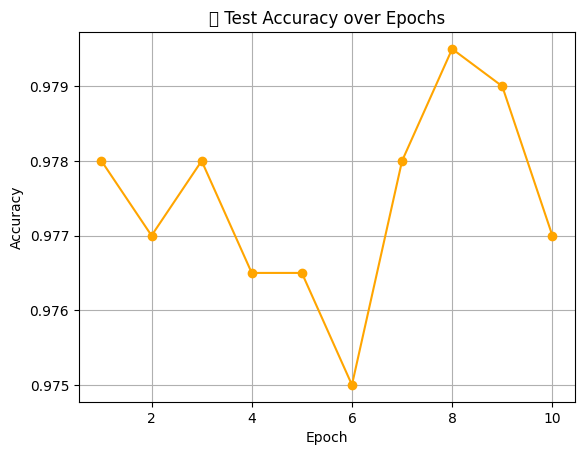

In [44]:
# 🔹 กราฟ Train Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('📉 Train Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 🔹 กราฟ Train Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Acc')
plt.title('✅ Train Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 🔹 กราฟ Test Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', color='orange', label='Test Acc')
plt.title('🧪 Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
